In [1]:
import numpy as np
from matplotlib import pyplot as plt

from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
from keras.models import Sequential
from keras.layers.core import Dense

from mydatools import img_plot

%matplotlib inline

Using TensorFlow backend.


In [2]:
# path = 'data/input/all/'
path = 'data/input/sample/'

In [28]:
def get_batches(dirname, gen=ImageDataGenerator(), shuffle=True, batch_size=4, class_mode='categorical',
                target_size=(224,224)):
    return gen.flow_from_directory(dirname, target_size=target_size,
            class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)

def get_data(path, target_size=(224,224)):
    batches = get_batches(path, shuffle=False, batch_size=1, target_size=target_size)
    X = np.concatenate([batches.next()[0] for i in range(batches.N)])
    y = np.concatenate([batches.next()[1] for i in range(batches.N)])
    return X, y

def get_class(a_onehot):
    return a_onehot.argmax(axis=1)

## 图片展示

In [4]:
batches = get_batches(path+'train', shuffle=False, batch_size=4)
val_batches = get_batches(path+'val', shuffle=False, batch_size=4)

Found 180 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


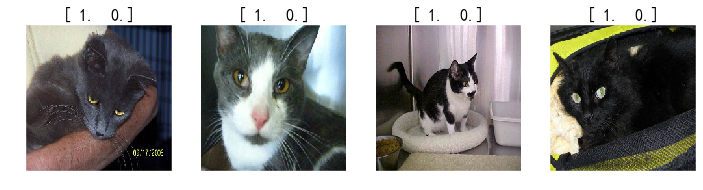

In [5]:
imgs, labels = next(batches)
img_plot.img_plots(imgs, titles=labels)

## VGG16 + Linear Model

使用VGG16对图片进行预测（这个时候，输出的类别有1000个，这是因为vgg本身是对1000各分类进行识别）

然后我们对vgg预测的结果进行一步线性模型的训练以及预测，将最终结果转化成2个分类（即猫和狗）

In [6]:
def fit_model(model, batches, val_batches, nb_epoch=1):
    model.fit_generator(batches, samples_per_epoch=batches.N, nb_epoch=nb_epoch, 
                        validation_data=val_batches, nb_val_samples=val_batches.N)

In [7]:
X_tra, y_tra = get_data(path+'train')
X_val, y_val = get_data(path+'val')

Found 180 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


In [29]:
y_tra_class = get_class(y_tra)
y_val_class = get_class(y_val)

In [8]:
# vgg16
model = VGG16()
model.compile(optimizer=RMSprop(lr=0.1), loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
# 使用vgg预测
vggres_tra = model.predict(X_tra)
vggres_val = model.predict(X_val)

In [10]:
# 可以看到预测的结果有1000个分类
vggres_tra.shape

(180, 1000)

In [11]:
# 使用线性模型
lm = Sequential()
lm.add(Dense(2, input_shape=(1000,), activation='softmax'))
lm.compile(optimizer=RMSprop(lr=0.1), loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
lm.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_1 (Dense)                  (None, 2)             2002        dense_input_1[0][0]              
Total params: 2002
____________________________________________________________________________________________________


In [19]:
lm.fit(vggres_tra, y_tra, batch_size=4, nb_epoch=3, validation_data=(vggres_val, y_val))

Train on 180 samples, validate on 20 samples
Epoch 1/3
180/180 [==============================] - 0s - loss: 0.3176 - acc: 0.9000 - val_loss: 0.1586 - val_acc: 0.9500
Epoch 2/3
180/180 [==============================] - 0s - loss: 0.1289 - acc: 0.9611 - val_loss: 0.1058 - val_acc: 0.9500
Epoch 3/3
180/180 [==============================] - 0s - loss: 0.0879 - acc: 0.9556 - val_loss: 0.1223 - val_acc: 0.9500


## View prediction result

In [20]:
pred_class = lm.predict_classes(vggres_val)
pred_proba = lm.predict_proba(vggres_val)

20/20 [==============================] - 0s


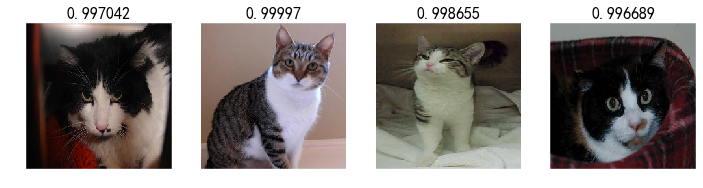

In [38]:
# 1. 展示正确的结果
cond = y_val_class == pred_class
show_imgs = X_val[cond][:4]
show_imgs_label = pred_proba[cond][:, 0][:4]
img_plot.img_plots(show_imgs, titles=show_imgs_label)

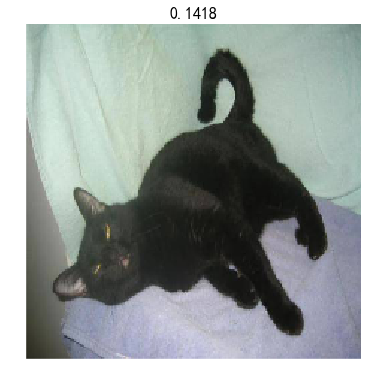

In [40]:
# 2. 展示错误的结果
cond = y_val_class != pred_class
show_imgs = X_val[cond][:4]
show_imgs_label = pred_proba[cond][:, 0][:4]
img_plot.img_plots(show_imgs, titles=show_imgs_label)

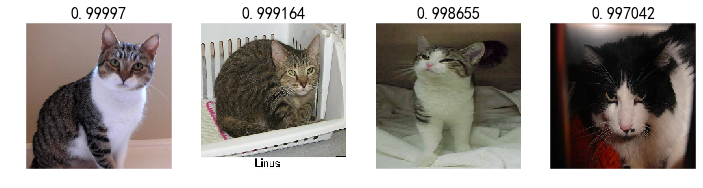

In [59]:
# 3. 展示最正确的结果
# 猫
class_id = 0
cond = (y_val_class == class_id) & (y_val_class == pred_class)
idx = pred_proba[cond][:, class_id].argsort()[::-1][:4]
show_imgs = X_val[cond][idx]
show_imgs_label = pred_proba[cond][idx][:, class_id]
img_plot.img_plots(show_imgs, titles=show_imgs_label)

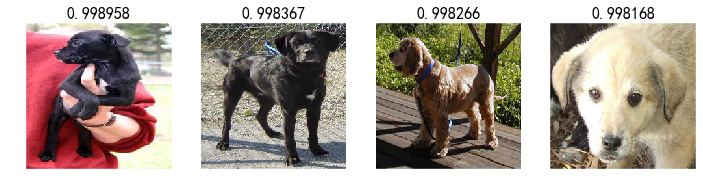

In [60]:
# 猫
class_id = 1
cond = (y_val_class == class_id) & (y_val_class == pred_class)
idx = pred_proba[cond][:, class_id].argsort()[::-1][:4]
show_imgs = X_val[cond][idx]
show_imgs_label = pred_proba[cond][idx][:, class_id]
img_plot.img_plots(show_imgs, titles=show_imgs_label)

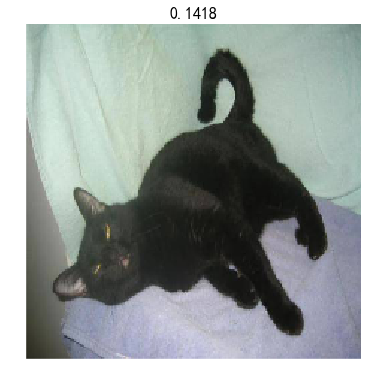

In [67]:
# 4. 展示最错误的结果
# 猫
class_id = 0
cond = (y_val_class == class_id) & (y_val_class != pred_class)
idx = pred_proba[cond][:, class_id].argsort()[:4]
show_imgs = X_val[cond][idx]
show_imgs_label = pred_proba[cond][idx][:, class_id]
img_plot.img_plots(show_imgs, titles=show_imgs_label)

In [68]:
# 狗
class_id = 1
cond = (y_val_class == class_id) & (y_val_class != pred_class)
idx = pred_proba[cond][:, class_id].argsort()[:4]
show_imgs = X_val[cond][idx]
show_imgs_label = pred_proba[cond][idx][:, class_id]
img_plot.img_plots(show_imgs, titles=show_imgs_label)

IndexError: index 0 is out of bounds for axis 0 with size 0

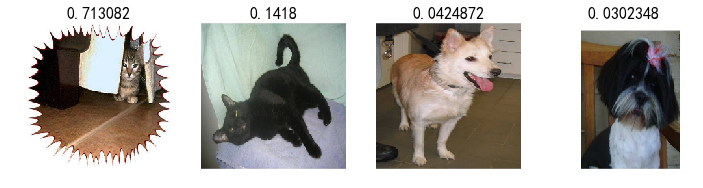

In [74]:
# 5. 最不确定的结果
idx = np.abs(pred_proba[:, 0] - 0.5).argsort()[:4]
show_imgs = X_val[idx]
show_imgs_label = pred_proba[idx][:, 0]
img_plot.img_plots(show_imgs, titles=show_imgs_label)

In [76]:
model.layers

In [78]:
first_dense_idx = [index for index,layer in enumerate(model.layers) if type(layer) is Dense][0]

In [79]:
first_dense_idx

20

In [80]:
model.layers[20:]

In [81]:
model.layers[12:]